## Izrada modela za izračunavanje jednostavnijih matematičkih operacija

### 1. Uključivanje potrebnih biblioteka te dohvaćanje dataseta

In [2]:
import torch
from torch import nn
import requests
import zipfile
from pathlib import Path
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from timeit import default_timer as timer
import torchvision
import cv2

torch.__version__

'2.1.0+cu121'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
data_path = Path("data/")
image_path = Path("data/")

with zipfile.ZipFile("./data.zip", "r") as zip_ref:
    print("Unzipping file")
    zip_ref.extractall(data_path)


Unzipping file


In [7]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [8]:
walk_through_dir("data/")

There are 2 directories and 0 images in data/
There are 14 directories and 0 images in data/test
There are 0 directories and 54 images in data/test/four
There are 0 directories and 54 images in data/test/seven
There are 0 directories and 54 images in data/test/five
There are 0 directories and 53 images in data/test/six
There are 0 directories and 55 images in data/test/one
There are 0 directories and 54 images in data/test/eight
There are 0 directories and 78 images in data/test/div
There are 0 directories and 52 images in data/test/zero
There are 0 directories and 54 images in data/test/three
There are 0 directories and 54 images in data/test/two
There are 0 directories and 54 images in data/test/nine
There are 0 directories and 80 images in data/test/times
There are 0 directories and 78 images in data/test/plus
There are 0 directories and 80 images in data/test/minus
There are 14 directories and 0 images in data/train
There are 0 directories and 7827 images in data/train/four
There a

In [9]:
train_dir = data_path / "train"
test_dir = data_path / "test"

### 2. Vizualizacija dataseta

In [10]:
random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

image_path_list[:5]

[PosixPath('data/test/four/39810.jpg'),
 PosixPath('data/test/four/52646.jpg'),
 PosixPath('data/test/four/73742.jpg'),
 PosixPath('data/test/four/24598.jpg'),
 PosixPath('data/test/four/25005.jpg')]

In [11]:
# Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

data/train/one/exp48777.jpg


In [12]:
# Get image clas from path name
image_class = random_image_path.parent.stem
image_class

'one'

Random image path: data/train/one/exp48777.jpg
Image class: one
Image height: 45 | Image widht: 45


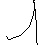

In [13]:
# Open image
img = Image.open(random_image_path)

# print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height} | Image widht: {img.width}")
img

(-0.5, 44.5, 44.5, -0.5)

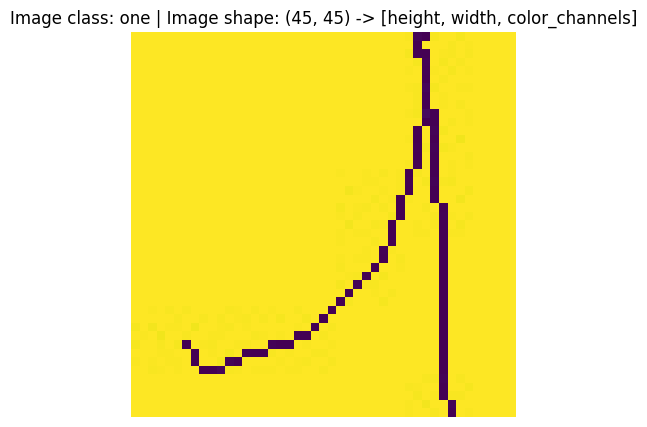

In [14]:
# Turn image into an array
image_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(image_as_array)
plt.title(f"Image class: {image_class} | Image shape: {image_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

In [15]:
data_transform = transforms.Compose([
    # Resize images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horoziontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn image into a torch tensor
    transforms.ToTensor()
])

In [16]:
data_transform(img).shape

torch.Size([1, 64, 64])

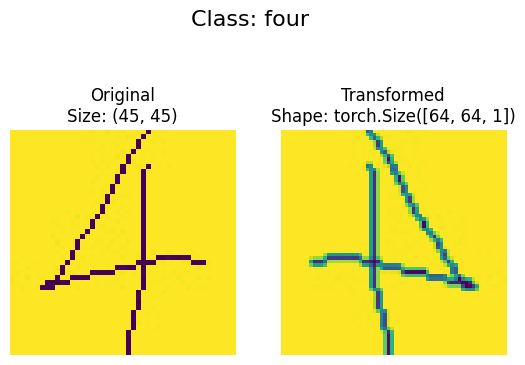

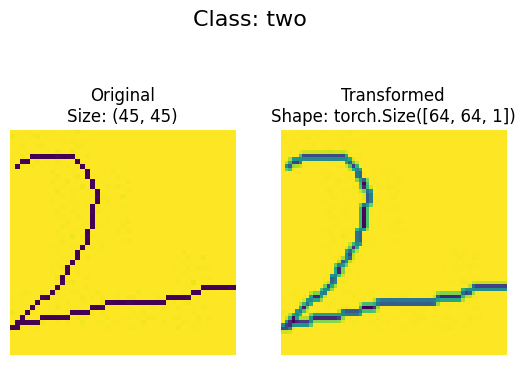

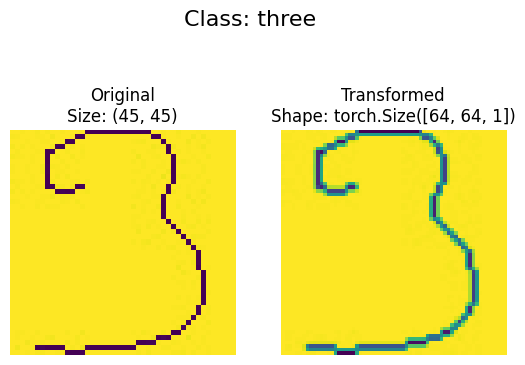

In [17]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
  #random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3, seed=42)

In [18]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  if n > 10:
    n = 10
    display_shape = False

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjust.shape}"
    plt.title(title)

In [19]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 163975
     Root location: data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 854
     Root location: data/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [20]:
len(train_data), len(test_data)

(163975, 854)

In [21]:
# Get class names as a list
class_names = train_data.classes
class_names

['div',
 'eight',
 'five',
 'four',
 'minus',
 'nine',
 'one',
 'plus',
 'seven',
 'six',
 'three',
 'times',
 'two',
 'zero']

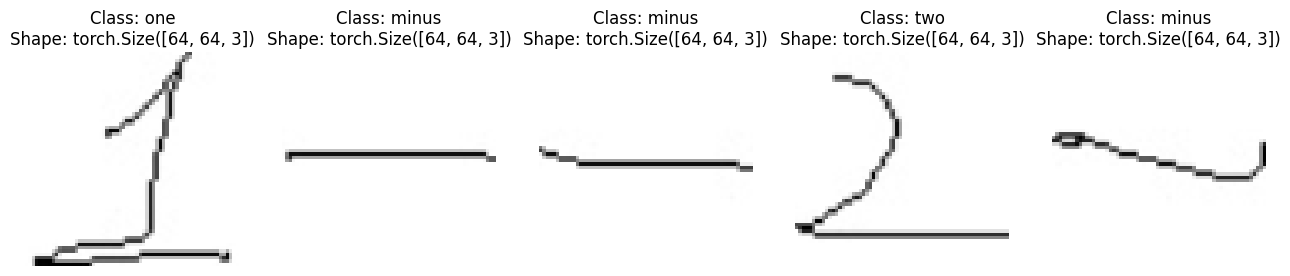

In [22]:
display_random_images(train_data, n=5, classes=class_names, seed=None)

### 3. Izgradnja i treniranje modela

In [23]:
# Load and transform data

simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

In [24]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU())
    self.conv2 = nn.Sequential(
                    nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                    nn.BatchNorm2d(out_channels))
    self.downsample = downsample
    self.relu = nn.ReLU()
    self.out_channels = out_channels

  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.conv2(out)
    if self.downsample:
        residual = self.downsample(x)
    out += residual
    out = self.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes = 14):
    super(ResNet, self).__init__()
    self.inplanes = 64
    self.conv1 = nn.Sequential(
                    nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1),
                    nn.BatchNorm2d(64),
                    nn.ReLU())
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
    self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
    self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
    self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
    self.avgpool = nn.AvgPool2d(2, stride=1)
    self.fc = nn.Linear(4608, num_classes)

  def _make_layer(self, block, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes:

        downsample = nn.Sequential(
            nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
            nn.BatchNorm2d(planes),
        )
    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample))
    self.inplanes = planes
    for i in range(1, blocks):
        layers.append(block(self.inplanes, planes))

    return nn.Sequential(*layers)


  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.layer0(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

In [25]:

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [26]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device=device):
  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels==y).sum().item() / len(test_pred_labels)

  test_loss /= len(dataloader)
  test_acc /= len(dataloader)

  return test_loss, test_acc

In [27]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs=5,
          device=device):

  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc= test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_acc"].append(test_acc)
    results["test_loss"].append(test_loss)

  return results

In [28]:
NUM_EPOCHS = 50

model_0 = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)

# Start tmer
start_time = timer()

# Train model
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)

# End timer
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds.")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.2225 | Train acc: 0.9528 | Test loss: 0.2906 | Test acc: 0.9176
Epoch: 1 | Train loss: 0.0268 | Train acc: 0.9928 | Test loss: 0.1492 | Test acc: 0.9555
Epoch: 2 | Train loss: 0.0198 | Train acc: 0.9947 | Test loss: 0.2970 | Test acc: 0.9244
Epoch: 3 | Train loss: 0.0178 | Train acc: 0.9949 | Test loss: 0.1497 | Test acc: 0.9556
Epoch: 4 | Train loss: 0.0145 | Train acc: 0.9961 | Test loss: 0.1181 | Test acc: 0.9610
Epoch: 5 | Train loss: 0.0135 | Train acc: 0.9965 | Test loss: 0.1680 | Test acc: 0.9510
Epoch: 6 | Train loss: 0.0131 | Train acc: 0.9966 | Test loss: 0.0821 | Test acc: 0.9755
Epoch: 7 | Train loss: 0.0121 | Train acc: 0.9970 | Test loss: 0.0602 | Test acc: 0.9800
Epoch: 8 | Train loss: 0.0123 | Train acc: 0.9971 | Test loss: 0.0870 | Test acc: 0.9821
Epoch: 9 | Train loss: 0.0113 | Train acc: 0.9974 | Test loss: 0.1515 | Test acc: 0.9567
Epoch: 10 | Train loss: 0.0118 | Train acc: 0.9970 | Test loss: 0.0830 | Test acc: 0.9755
Epoch: 11 | Train lo

### 4. Testiranje modela

In [29]:
def pred_and_plot_image(model: torch.nn.Module,
                        image: torch.Tensor,
                        class_names,
                        transform,
                        device=device):
    model.to(device)
    model.eval()

    with torch.inference_mode():
        image = transform(image.unsqueeze(dim=0).to(device))
        image_logits = model(image)

    # Convert logits to probs
    image_probs = torch.softmax(image_logits, dim=1)
    image_label = torch.argmax(image_probs, dim=1)

    image = image.cpu()

    # Plot
    plt.imshow(image.squeeze(), cmap='gray')
    if class_names:
        plt.title(f"Class: {class_names[image_label]} | Prob: {image_probs.max():.4f}")
    else:
        plt.title(f"Class: {image_label} | Prob: {image_probs.max().cpu():.4f}")

    plt.axis(False)
    plt.show()

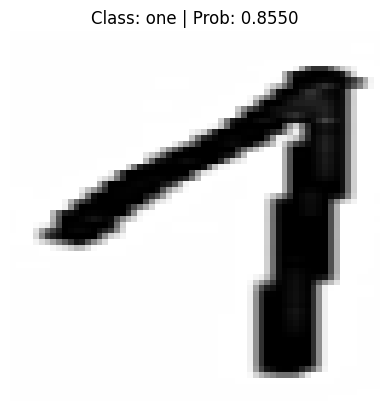

In [63]:
custom_image_path = Path("./test_dir/split_1.jpg")
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float) / 255

transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.Grayscale(num_output_channels=1),
])

pred_and_plot_image(model=model_0,
                    image=custom_image,
                    class_names=class_names,
                    transform=transform,
                    device=device)

### 5. Separacija unesene slike na matematičke jedinke

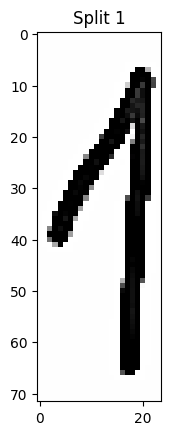

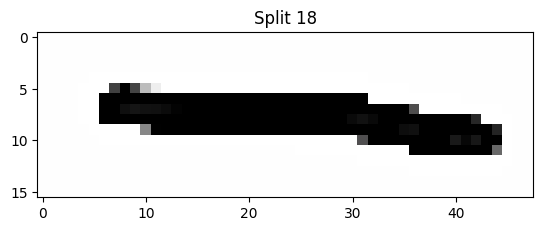

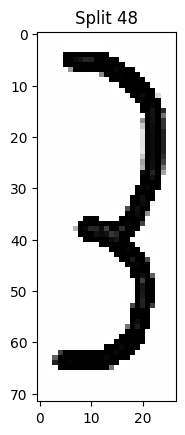

In [62]:
def increase_width(cropped_region, new_width):
    # Create a blank white image with the desired width
    new_image = np.ones((cropped_region.shape[0], new_width), dtype=np.uint8) * 255

    # Calculate the position to paste the cropped region
    x_offset = (new_width - cropped_region.shape[1]) // 2

    # Paste the cropped region onto the new image
    new_image[:, x_offset:x_offset + cropped_region.shape[1]] = cropped_region

    return new_image


def split_image_by_black_pixels(image_path, output_list):
    # Convert image content to NumPy array
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_color = cv2.imread(image_path, cv2.IMREAD_COLOR)
    height, width = image.shape

    # Invert the image so that black pixels become white
    inverted_image = cv2.bitwise_not(image)

    # Find contours in the inverted image
    contours, _ = cv2.findContours(inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by x-coordinate
    contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])

    # Iterate through contours and append regions without black pixels to the list
    cropped_regions = []
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)

        # Filter out small regions
        if w > 10 and h > 10:  # Adjust the threshold as needed
            # Crop the region without black pixels
            cropped_region = image[y:y+h, x:x+w]
            dict_cropped_region = {'x': x, "y": y, "w":w, "h": h, "is_div": False}

            is_part_of_bigger = False

            for i, tmp_region in enumerate(cropped_regions):
              if (
                  dict_cropped_region["x"] >= tmp_region["x"] - 5
                  and dict_cropped_region["x"] + dict_cropped_region["w"] <= tmp_region["x"] + tmp_region["w"] + 5
              ):
                  tmp_region["y"] = 0
                  tmp_region["h"] = height
                  tmp_region["is_div"] = True
                  cropped_regions[i] = tmp_region
                  is_part_of_bigger = True

            if is_part_of_bigger:
              continue

            cropped_regions.append(dict_cropped_region)

    for region in cropped_regions:
      cropped_region = image[region["y"]:region["y"]+region["h"], region["x"]:region["x"]+region["w"]]
      output_list.append(cropped_region)
      plt.imshow(increase_width(cropped_region, 512), cmap='gray')  # Use 'gray' colormap for grayscale images
      plt.title(f"Split {i}")
      plt.show()

image_path = "test2.jpg"
output_images = []

split_image_by_black_pixels(image_path, output_images)

### 5. Pohrana modela

In [30]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "simple_photomath.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/simple_photomath_3.pth
